# [실습2] LangGraph를 활용한 엑셀 데이터를 활용하는 챗봇

## 실습 목표
---
1. LangGraph를 활용해서 사용자의 질문에 따라 질문에 바로 답하거나, 엑셀 데이터를 활용해서 답하는 챗봇을 만들어 봅시다.

## 실습 목차
---

1. **엑셀 데이터를 활용하는 챗봇:** LangGraph를 활용해서 엑셀 데이터를 선택적으로 활용하는 챗봇을 구성합니다.

## 실습 개요
---
LangChain을 활용해서 자연어로 데이터를 분석할 수 있는 챗봇을 구현하고 사용해봅니다.

## 0. 환경 설정
- 필요한 라이브러리를 불러옵니다.

In [1]:
import contextlib
import io
import os

import pandas as pd
from IPython.display import Image, display
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict

- Ollama를 통해 Mistral 7B 모델을 불러옵니다.

In [2]:
!ollama pull mistral:7b

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████▏ 4.1 GB                         
pulling 43070e2d4e53... 100% ▕████████████████▏  11 KB                         pulling manifest 
pulling ff82381e2bea... 100% ▕████████████████

## 1. 엑셀 데이터를 활용하는 챗봇
- LangGraph를 활용해서 엑셀 데이터를 선택적으로 활용하는 챗봇을 구성합니다.
- 이번 실습에 사용할 데이터는 2일차 실습 중 **Langchain을 이용한 머신러닝 기반 데이터 분석 실무 프로젝트** 에 사용하는 데이터입니다.
 
저희는 이전 실습에서 원하는 데이터를 자연어로 입력하면, 이를 바탕으로 자동으로 코드를 생성하고 결과를 반환하는 체인을 구성했습니다. 

여기서 더 나아가서, LangGraph를 활용해서 엑셀 데이터를 선택적으로 활용한 후 자연어로 대답하는 챗봇을 만들어 봅시다.

먼저, mistral:7b 모델을 사용하는 ChatOllama 객체를 생성하고, 데이터를 불러옵니다.

In [3]:
llm = ChatOllama(model="mistral:7b")

# 데이터를 불러오고, 이름과 컬럼명을 저장합니다.
data_dir = './data'
df_inkjet = pd.read_csv(os.path.join(data_dir, 'InkjetDB_preprocessing.csv'), index_col=0)

# 데이터를 저장한 변수명을 LLM에 제공하여 이 변수를 활용하는 코드를 작성하게 할 수 있습니다.
df_name = "df_inkjet"
df_columns = ", ".join(df_inkjet.columns)

이전 실습에서 사용한 코드를 파싱하고 실행하는 함수를 정의합니다.

In [4]:
# LLM이 생성한 코드를 파싱하는 함수를 정의합니다.
def python_code_parser(input: str) -> str:
    # LLM은 대부분 ``` 블럭 안에 코드를 출력합니다. 이를 활용합니다.
    # ```python (코드) ```, 혹은 ``` (코드) ``` 형태로 출력됩니다. 두 경우 모두에 대응하도록 코드를 작성합니다.
    processed_input = input.replace("```python", "```").strip()
    parsed_input_list = processed_input.split("```")

    # 만약 ``` 블럭이 없다면, 입력 텍스트 전체가 코드라고 간주합니다.
    # 아닐 경우 이어지는 코드 실행 과정에서 예외 처리를 통해 오류를 확인할 수 있습니다.
    if len(parsed_input_list) == 1:
        return processed_input

    # 코드 부분만 추출합니다. 
    # LLM은 여러 코드 블럭에 걸쳐 필요한 코드를 출력할 수 있으므로, 코드가 있는 홀수 번째 텍스트를 모두 저장합니다.
    parsed_code_list = []
    for i in range(1, len(parsed_input_list), 2):
        parsed_code_list.append(parsed_input_list[i])
    
    # 코드 부분을 하나로 합칩니다.
    return "\n".join(parsed_code_list)

# 생성한 코드를 실행하는 함수를 정의합니다.
def run_code(input_code: str):
    # 코드가 출력한 값을 캡쳐하기 위한 StringIO 객체를 생성합니다.
    output = io.StringIO()
    try:
        # Redirect stdout to the StringIO object
        with contextlib.redirect_stdout(output):
            # Python 3.10 버전이므로, 키워드 인자를 사용할 수 없습니다.
            # 코드가 실행하면서 출력한 모든 결과를 캡쳐합니다.
            exec(input_code, {"df_inkjet": df_inkjet})
    except Exception as e:
        # 에러가 발생할 경우, 이를 StringIO 객체에 저장합니다.
        print(f"Error: {e}", file=output)
    # StringIO 객체에 저장된 값을 반환합니다.
    return output.getvalue()

In [5]:
def find_data(question: str) -> str:
    """입력한 질문을 위한 데이터 쿼리 코드를 생성하여 실행한 후 결과를 반환하는 Tool."""
        # 프롬프트를 정의합니다.
    system_message = "당신은 주어진 데이터를 분석하는 데이터 분석가입니다.\n"
    system_message += f"주어진 DataFrame에서 데이터를 출력하여 주어진 질문에 답할 수 있는 파이썬 코드를 작성하세요. "
    system_message += f"{df_name} DataFrame에 액세스할 수 있습니다.\n"
    system_message += f"`{df_name}` DataFrame에는 다음과 같은 열이 있습니다: {df_columns}\n"
    system_message += "데이터는 이미 로드되어 있으므로 데이터 로드 코드를 생략해야 합니다."

    message_with_data_info = [
        ("system", system_message),
        ("human", "{question}"),
    ]

    prompt_with_data_info = ChatPromptTemplate.from_messages(message_with_data_info)

    # 체인을 구성합니다.
    code_generate_chain = (
        {"question": RunnablePassthrough()}
        | prompt_with_data_info
        | llm 
        | StrOutputParser()
        | python_code_parser
    )
    code = code_generate_chain.invoke(question)
    answer = run_code(code)
    
    return {'code': code, 'data': answer}

실습1 과 같이, `State` class를 정의해서 그래프의 각 구성 요소 간에 전달할 정보의 속성을 정의합니다.

그리고 `StateGraph` 객체를 생성합니다.

In [6]:
class State(TypedDict):
    # 그래프 상태의 속성을 정의합니다.
    # 질문, LLM이 생성한 텍스트, 데이터, 코드를 저장합니다.
    question: str #문자열 타입의 질문 내용을 저장합니다.
    generation: str #LLM(Large Language Model)이 생성한 텍스트 결과를 문자열로 저장합니다.
    data: str #분석 결과와 관련된 데이터를 문자열로 저장합니다.
    code: str #실행할 코드를 문자열 형태로 저장합니다.
        
# 그래프를 구성하기 위해 StateGraph 객체를 생성합니다.
# 생성자의 인자로 State를 전달하여 Node 간에 정보를 전달할 때 State type을 사용함을 명시합니다.
workflow = StateGraph(State)

그래프는 Node와 Edge로 구성되어 있습니다.

Node는 체인의 각 구성 요소에 대응합니다. Agent, Tool, LLM 등 그래프의 각 구성 요소를 의미합니다.

Edge는 Node를 연결하는 요소로, Node에서 정보를 어느 Node로 전달해야 하는지를 나타냅니다.
- 체인은 일렬로 이어져 있기 때문에, 사용자의 입력을 연결된 순서대로 통과시키면 원하는 결과를 얻을 수 있습니다.
- 하지만, 그래프는 일렬로 이어져 있지 않기 때문에 Edge를 통해 정보를 전달하는 순서 및 방향을 정해줘야 합니다.

이번 실습에서는 조건부로 바로 답변하거나, 데이터를 불러오는 코드를 생성하고 실행한 결과를 바탕으로 답변하는 챗봇을 만들어 볼 것입니다.<br>
여기서 조건과 경로를 Edge를 활용해 구현할 수 있습니다. 

In [7]:
## Node 생성
# Node는 그래프에서 실행될 수 있는 작업을 정의합니다.
# Node는 함수로 정의되며, StateGraph를 정의할 때 사용한 State type을 입력으로 받습니다.
# Node는 state를 업데이트하거나, 새로운 state를 반환할 수 있습니다.
def init_answer(state: State) -> str:
    """
    코드 생성 프롬프트를 활용해서, 코드를 생성해야 할지, 그냥 답하면 될 지 결정하고 답변합니다.
    이 답변을 활용해서 다른 함수에서 데이터 쿼리를 진행할 지, 바로 답변 생성을 진행할 지 결정합니다.

    Args:
        state (dict): 현재 그래프 상태

    Returns:
        state (dict): LLM의 답변을 포함한 새로운 State
    """
    print("---데이터 추출 필요성 확인---") # 현재 상태를 확인하기 위한 Print문
    question = state["question"]
    llm = ChatOpenAI(
        api_key="ollama",
        model="mistral:7b",
        base_url="http://localhost:11434/v1",
        streaming=True
    )
    decide_system_message = "당신은 주어진 데이터를 분석하는 데이터 분석가입니다.\n"
    decide_system_message += f"주어진 DataFrame에서 데이터를 출력하여 주어진 질문에 답할 수 있는 파이썬 코드를 작성하세요. "
    decide_system_message += f"{df_name} DataFrame에 액세스할 수 있습니다.\n"
    decide_system_message += f"`{df_name}` DataFrame에는 다음과 같은 열이 있습니다: {df_columns}\n"
    decide_system_message += "데이터는 이미 로드되어 있으므로 데이터 로드 코드를 생략해야 합니다."
    decide_system_message += "주어진 질문이 데이터와 무관하다면, 파이썬 코드를 생성하지 말고 주어진 질문에 답하세요."
    decide_user_message = "{question}"
    decide_prompt = ChatPromptTemplate.from_messages([
        ("system", decide_system_message),
        ("human", decide_user_message)
    ])
    
    decide_chain = {"question": RunnablePassthrough()} | decide_prompt | llm
    
    generation = decide_chain.invoke(question)  
    return {"question": question, "generation": generation.content}


def query(state: State):
    """
    데이터를 쿼리하는 코드를 생성하고, 실행하고, 그 결과를 포함한 State를 반환합니다.
    위 과정은 앞서 정의한 `find_data` 함수를 활용합니다.

    Args:
        state (dict): 현재 그래프 상태

    Returns:
        state (dict): 쿼리한 데이터를 포함한 새로운 State
    """
    print("---데이터 쿼리---") # 현재 상태를 확인하기 위한 Print문
    question = state["question"]

    # Retrieval
    data = find_data(question)
    return {"question": question, "code": data['code'], "data": data['data'], "generation": data['code']}

def answer_with_data(state: State):
    """
    쿼리한 데이터를 바탕으로 답변을 생성합니다.

    Args:
        state (dict): 현재 그래프 상태

    Returns:
        state (dict): LLM의 답변을 포함한 새로운 State
    """
    print("---데이터 기반 답변 생성---") # 현재 상태를 확인하기 위한 Print문
    question = state["question"]
    data = state["data"]

    # 데이터를 바탕으로 질문에 대답하는 코드를 생성합니다.
    reasoning_system_message = "당신은 데이터를 바탕으로 질문에 답하는 데이터 분석가입니다.\n"
    reasoning_system_message += f"사용자가 입력한 데이터를 바탕으로, 질문에 대답하세요."

    reasoning_user_message = "데이터: {data}\n{question}"

    reasoning_with_data = [
        ("system", reasoning_system_message),
        ("human", reasoning_user_message),
    ]
    reasoning_with_data_chain = ChatPromptTemplate.from_messages(reasoning_with_data) | llm | StrOutputParser()
    
    # 대답 생성
    generation = reasoning_with_data_chain.invoke({"data": data, "question": question})
    return {"question": question, "code": state['code'], "data": data, "generation": generation}


    
def answer(state: State):
    """
    데이터를 쿼리하지 않고 답변을 바로 생성합니다.

    Args:
        state (dict): 현재 그래프 상태

    Returns:
        state (dict): LLM의 답변을 포함한 새로운 State
    """
    print("---답변 생성---") # 현재 상태를 확인하기 위한 Print문
    question = state["question"]
    
    return {"question": question, "generation": llm.invoke(question).content}   

init_answer 함수의 시스템 프롬프트를 확인해보면, '주어진 질문이 데이터와 무관하다면, 파이썬 코드를 생성하지 말고 주어진 질문에 답하세요.' 라는 문장이 있습니다.

이는 데이터과 유관한 질문을 했을 경우 코드를 생성하고, 그렇지 않다면 일반 답변을 생성하도록 유도하는 프롬프트입니다.
- 여기서 생성된 답변을 바로 출력하거나 사용하지 않는 이유는, 두 경우에 모두 대응하기 위해 시스템 프롬프트를 불필요하게 길게 설정하여 전체적인 답변의 퀄리티가 떨어지기 떄문입니다.

즉, 코드가 생성되어 ```python 으로 시작한 블럭이 있다면 코드 생성 분기로 넘기고, 그렇지 않다면 단순 답변 분기로 넘기면 될 것입니다.

`decide_query` 함수를 통해 이 로직을 구현합니다.

In [8]:
# 'decide_query' 함수 정의: 'state'라는 딕셔너리 형태의 인자를 받아서 처리하고
# 조건에 따라 "query" 또는 "answer" 문자열을 반환하는 함수입니다.
def decide_query(state: State) -> str:
    
    # state 딕셔너리에서 "generation" 키에 해당하는 값을 가져옴
    # 이 값은 어떤 모델 또는 시스템이 생성한 응답일 것으로 추정됨
    generation = state["generation"]
    
    # 응답된 generation 값을 콘솔에 출력하여 디버깅 및 확인용으로 사용
    print(f"Response: {generation}")
    
    # 만약 generation 문자열 내에 "```python"이라는 코드 블록이 포함되어 있는 경우
    # (대소문자 구분 없이 검색하기 위해 .lower() 메서드를 사용)
    if "```python" in generation.lower():
        # "query"라는 문자열을 반환하여 해당 노드로 이동
        return "query"  # "query" 노드로 이동

    # 위 조건이 만족되지 않는 경우 (즉, 코드 블록이 포함되지 않은 경우)
    else:
        # "answer"라는 문자열을 반환하여 해당 노드로 이동
        return "answer"  # "answer" 노드로 이동


지난 실습과 달리 총 4개의 노드를 사용하고, 조건에 따라 사용하는 노드가 달라집니다.

이를 구현하기 위해, 노드와 간선을 그래프에 추가합니다.

In [9]:
## 그래프 구성

# 1. 앞서 정의한 각 Node를 그래프에 추가합니다.
# Node는 워크플로우의 특정 단계를 의미하며, 각 노드는 함수 또는 처리 로직을 담당합니다.
workflow.add_node("init_answer", init_answer)  # 첫 번째 노드, 초기 답변을 처리하는 함수
workflow.add_node("query", query)              # 사용자의 질문을 처리하는 노드
workflow.add_node("answer", answer)            # 단순한 응답을 처리하는 노드
workflow.add_node("answer_with_data", answer_with_data)  # 데이터 기반의 응답을 처리하는 노드

# 2. 그래프의 시작 지점을 정의합니다.
# 이 워크플로우가 실행될 때 가장 먼저 실행되는 노드를 지정합니다.
workflow.set_entry_point("init_answer")  # init_answer 노드가 가장 먼저 실행됩니다.

# 3. 그래프의 간선을 정의합니다.
# 간선은 노드 간의 순서 및 흐름을 나타냅니다.
# END는 해당 경로의 종료를 의미합니다.

workflow.add_edge("answer", END)  # answer 노드에서 END로 연결 (answer가 종료 지점)
# 위 코드와 동일한 의미: workflow.set_finish_point("answer")

workflow.add_edge("answer_with_data", END)  # answer_with_data 노드에서 END로 연결 (종료 지점)
workflow.add_edge("query", "answer_with_data")  # query 노드가 실행된 후 answer_with_data로 이어집니다.

# 4. 조건부 간선을 정의합니다.
# 특정 조건에 따라 서로 다른 경로로 이동하도록 설정합니다.
# init_answer 노드의 결과에 따라 decide_query 함수가 분기 처리를 수행합니다.

workflow.add_conditional_edges(
    "init_answer",  # 조건부 분기의 출발 노드 (init_answer)
    decide_query,   # 조건을 평가하는 함수. 결과에 따라 어느 노드로 이동할지 결정합니다.
    {
        "query": "query",   # decide_query의 결과가 "query"일 경우 query 노드로 이동
        "answer": "answer"  # decide_query의 결과가 "answer"일 경우 answer 노드로 이동
    }
)
# 이 조건부 간선은 그래프의 유연성을 높여, 처리 흐름을 상황에 맞게 분기할 수 있도록 도와줍니다.
# 결정 로직이 명확해지므로 그래프의 가독성과 유지보수성이 향상됩니다.


Node, Edge, 분기를 모두 구성했으니 이제 그래프를 컴파일 하고, 그 구조를 확인해 봅시다.

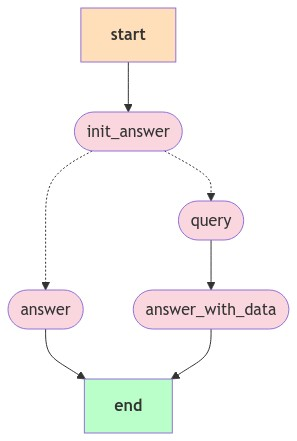

In [10]:
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

이제 챗봇을 사용해봅시다. 
- 예시 질문 (데이터 활용): Velocity가 가장 큰 데이터를 알려줘
- 예시 질문 (데이터 무관): 오늘 점심으로 뭐 먹을까?

In [ ]:
# 무한 루프를 시작합니다. 사용자가 '종료'를 입력하기 전까지 계속 반복합니다.
while True:
    # 사용자의 질문을 입력받습니다.
    question = input("질문을 입력해주세요 (종료를 원하시면 '종료'를 입력해주세요.): ")

    # 만약 사용자가 '종료'를 입력하면 루프를 종료합니다.
    if question == "종료":
        break
    else:
        # 사용자가 입력한 질문을 'graph.stream()'에 전달하여 그래프를 실행합니다.
        # 'graph'는 Langchain의 StateGraph 객체로, 워크플로우에 따라 여러 노드를 처리합니다.
        # stream() 메서드는 노드의 실행 결과를 이벤트로 순차적으로 반환합니다.
        for event in graph.stream({"question": ("user", question)}):
            
            # 각 이벤트의 결과 값들을 순회합니다.
            # event.values()는 실행된 각 노드의 결과를 포함합니다.
            for value in event.values():
                # 노드의 전체 결과를 출력합니다.
                print(value)

                # 'generation' 키에 포함된 응답 텍스트를 추출하여 출력합니다.
                # 이 값은 AI 모델이 생성한 응답일 가능성이 큽니다.
                print("Assistant:", value["generation"])


왜 invoke가 아닌 stream()을 사용했을까?

실시간 피드백 제공

스트리밍 방식은 각 노드가 실행되면서 나온 중간 결과를 즉시 반환합니다.
챗봇처럼 대화형 시스템에서는 사용자가 질문을 던진 후, 가능한 빨리 응답을 받는 것이 중요합니다. 
invoke()는 모든 프로세스가 끝난 후 결과를 반환하므로 사용자 대기 시간이 길어질 수 있습니다.

복잡한 워크플로 지원

질문이 여러 노드를 거치며 처리된다면, 각 노드의 결과를 실시간으로 확인하는 것이 중요할 수 있습니다. 
예를 들어, AI 모델이 여러 단계를 통해 응답을 생성하거나 외부 API를 호출하는 경우, 
중간 결과를 보여주는 것이 사용자 경험을 향상시킵니다.

대규모 작업 처리에 적합

처리 시간이 오래 걸리는 작업의 경우 stream()은 노드가 완료될 때마다 
진행 상황을 출력할 수 있어 사용자에게 유용한 정보를 제공합니다.

### 추가 실습
- 현재 프롬프트는 데이터 분석이 필요 없는 일부 질문 (Mistral에 대해 설명해줘 등) 에 대해서도 데이터 분석을 시도하기도 합니다.
- 다음 실습에서는 이를 개선해볼 것입니다. 그 전에, 프롬프트를 개선해서 이러한 현상을 완화해보세요.

In [ ]:
# 아래 코드의 주석을 해제하고 실행하면 본 실습에서 다운받은 모델 파일을 삭제합니다.
# 각 실습에서 같은 모델이라도 다시 다운 받기 때문에, 
# 실습이 종료되었으면 아래 명령어를 실행하여 불필요한 파일을 삭제하는 것이 좋습니다.
# !rm -rf .ollama/models/*